# EDA
## Import libraries

In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline # For SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # For Undersampling
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA

## Load dataset and structure

In [360]:
# Load data and check dimensions
df = pd.read_csv("ILPD.csv")   
print("\n### Data Dimensions:", df.shape)

print("\n### Variable Types:\n", df.dtypes)

# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('Dataset')  # Remove target variable from features

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("\n### Numerical Features (", len(numerical_features), "):", numerical_features)
print("\n### Categorical Features (", len(categorical_features), "):", categorical_features)

# Display data preview and summary statistics
print("\n### First Rows:\n", df.head())
print("\n### Summary Statistics:\n", df.describe(include='all'))

# Show distribution of categorical variables
print("\n### Gender Distribution:")
print(df['Gender'].value_counts())


### Data Dimensions: (583, 11)

### Variable Types:
 Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

### Numerical Features ( 9 ): ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

### Categorical Features ( 1 ): ['Gender']

### First Rows:
    Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62  

## Missing values

In [361]:
print("\n### Missing Values per Column:\n")

print(df.isnull().sum())


### Missing Values per Column:

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64


## Target (Class) Distribution


### Target Distribution:

Dataset
1    416
2    167
Name: count, dtype: int64


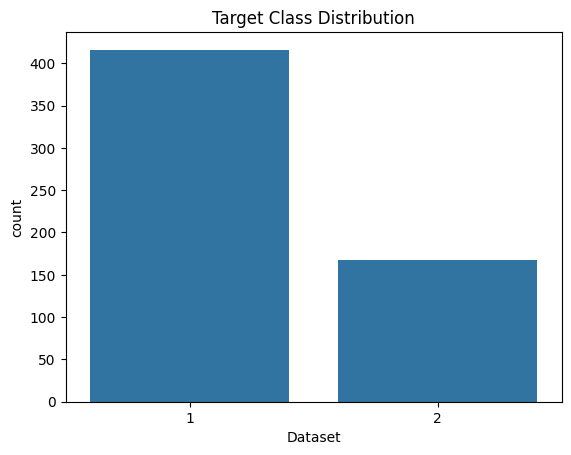

In [362]:
target_col = df['Dataset']   # 1 = Diseased, 2 = Healthy
print("\n### Target Distribution:\n")
print(target_col.value_counts())

sns.countplot(x=target_col, data=df)
plt.title("Target Class Distribution")
plt.show()

In [363]:
# Replace target values with 0/1 for numerical analysis
# In the ILPD dataset: 1 = diseased, 2 = healthy
df['diseased'] = df['Dataset'].apply(lambda x: 1 if x == 1 else 0)
df.drop(columns=['Dataset'], inplace=True)

## Distributions (Histograms + Density)

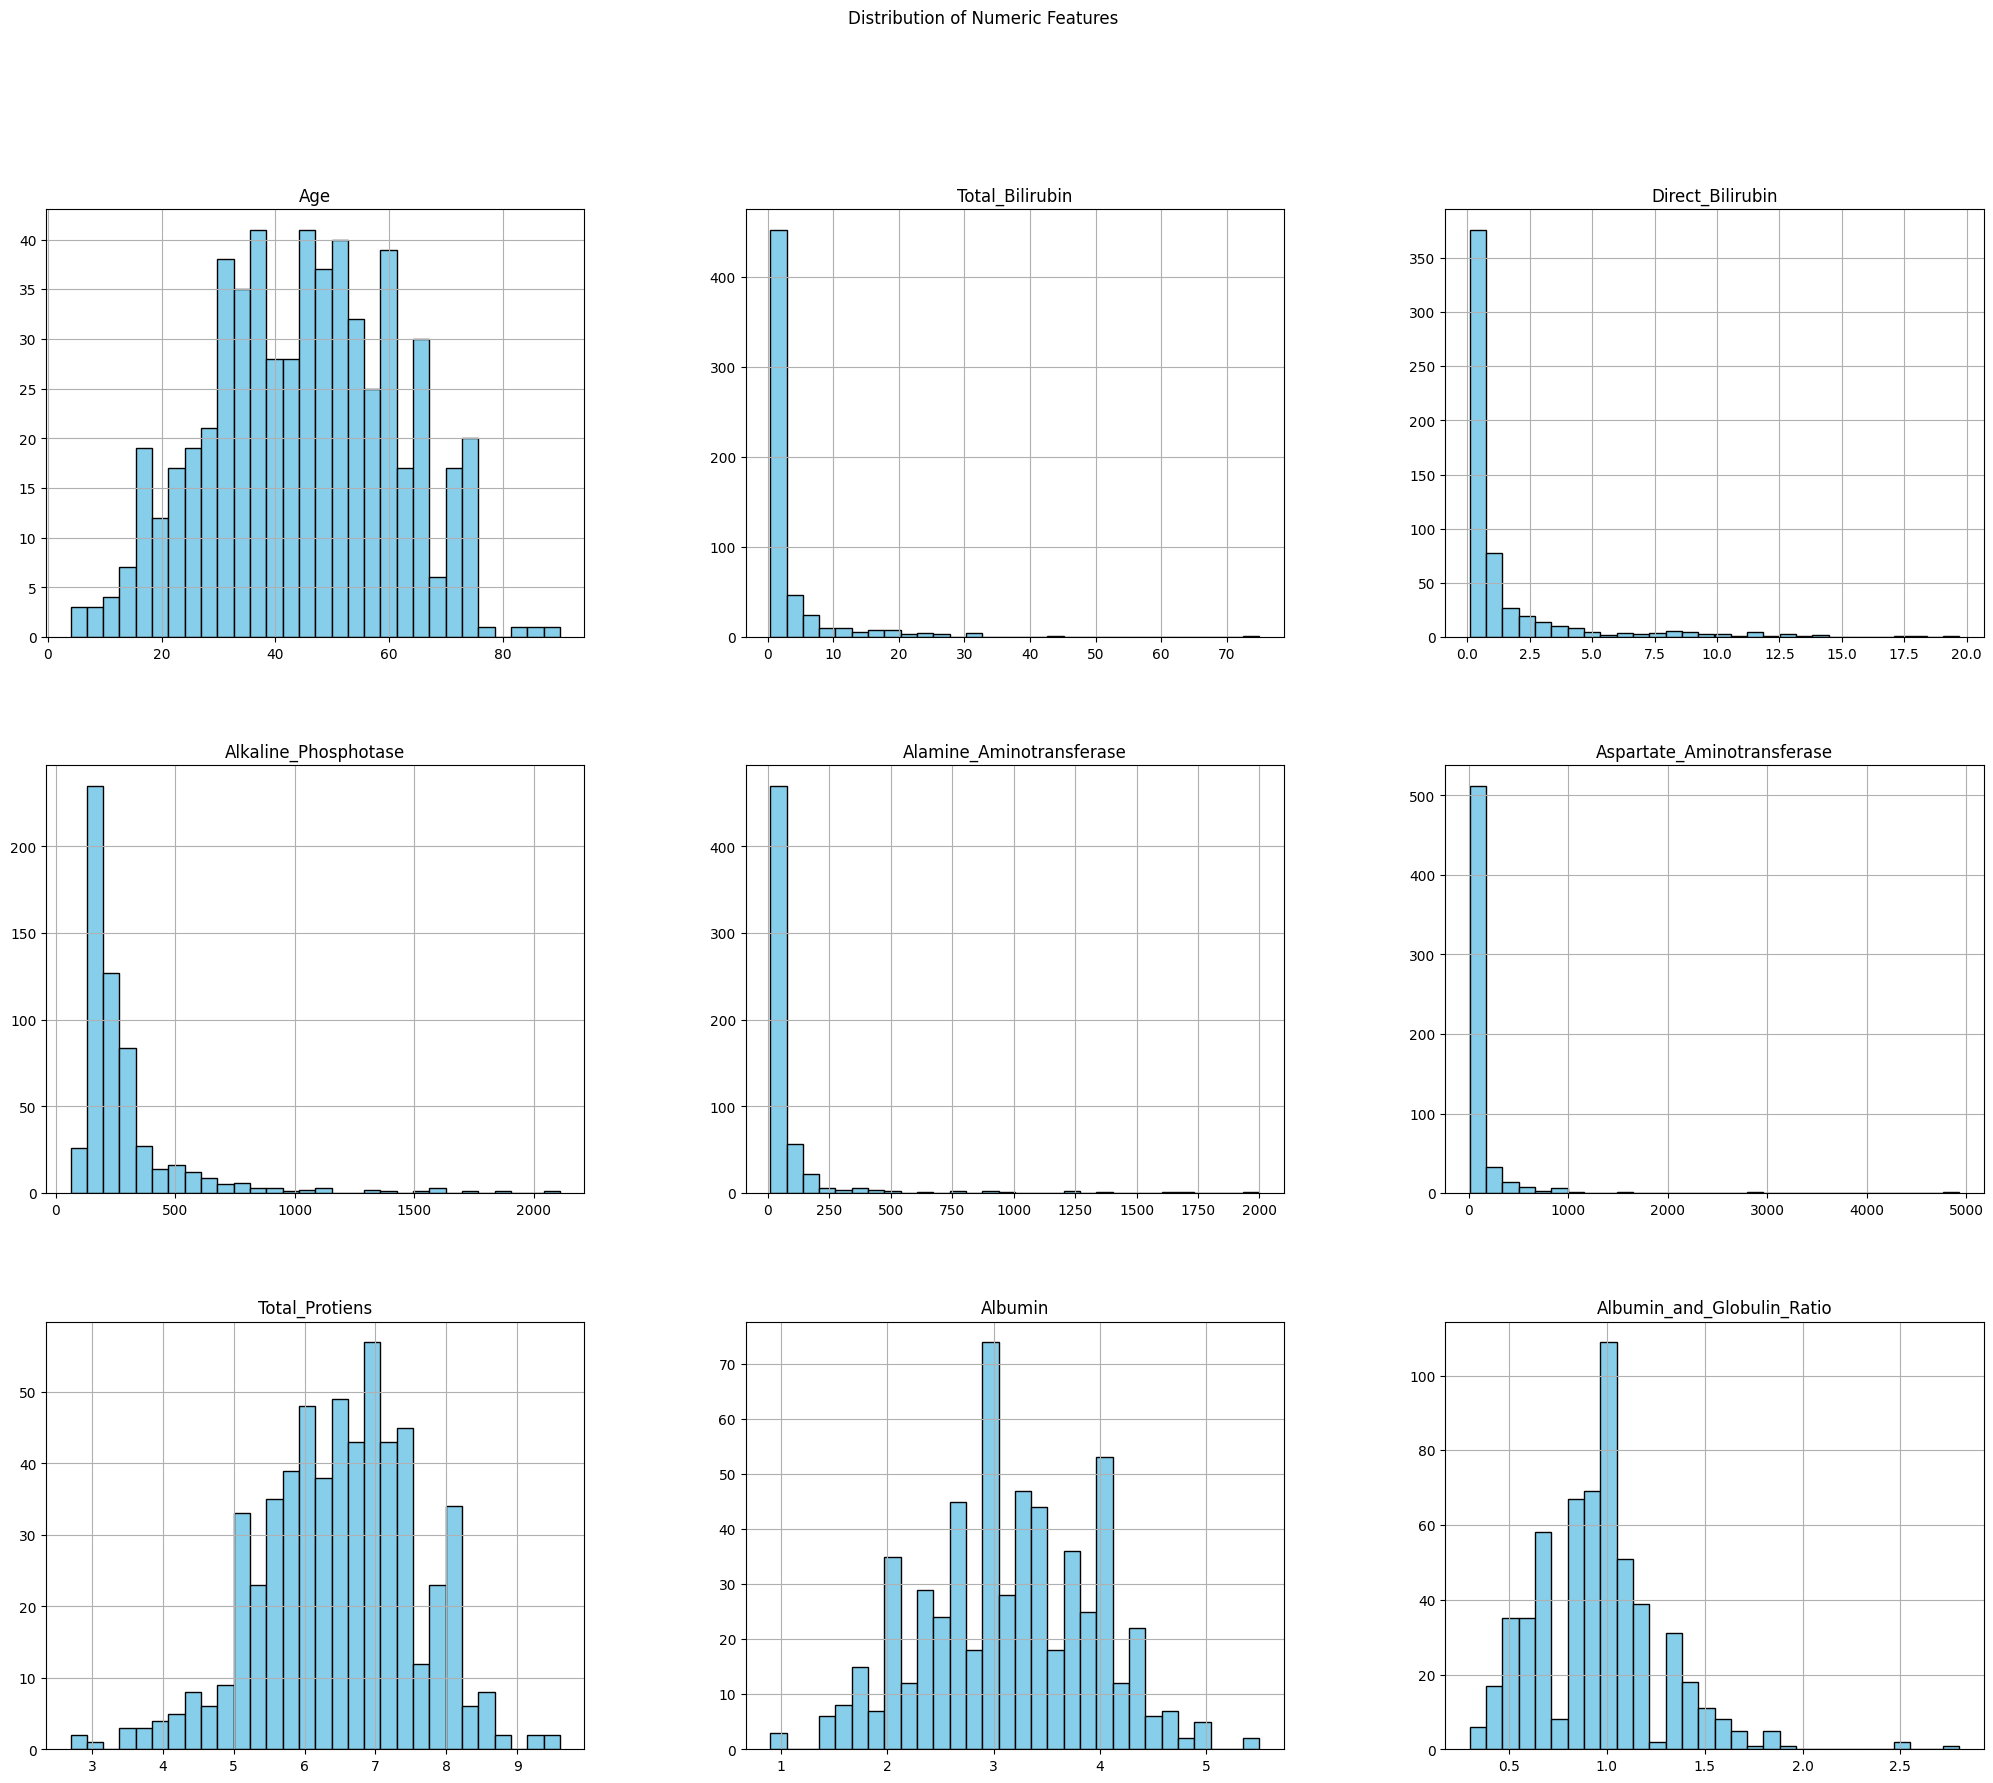

In [364]:
df[numerical_features].hist(bins=30, figsize=(25, 20), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=12)
plt.show()

## Outlier Detection (Boxplots)

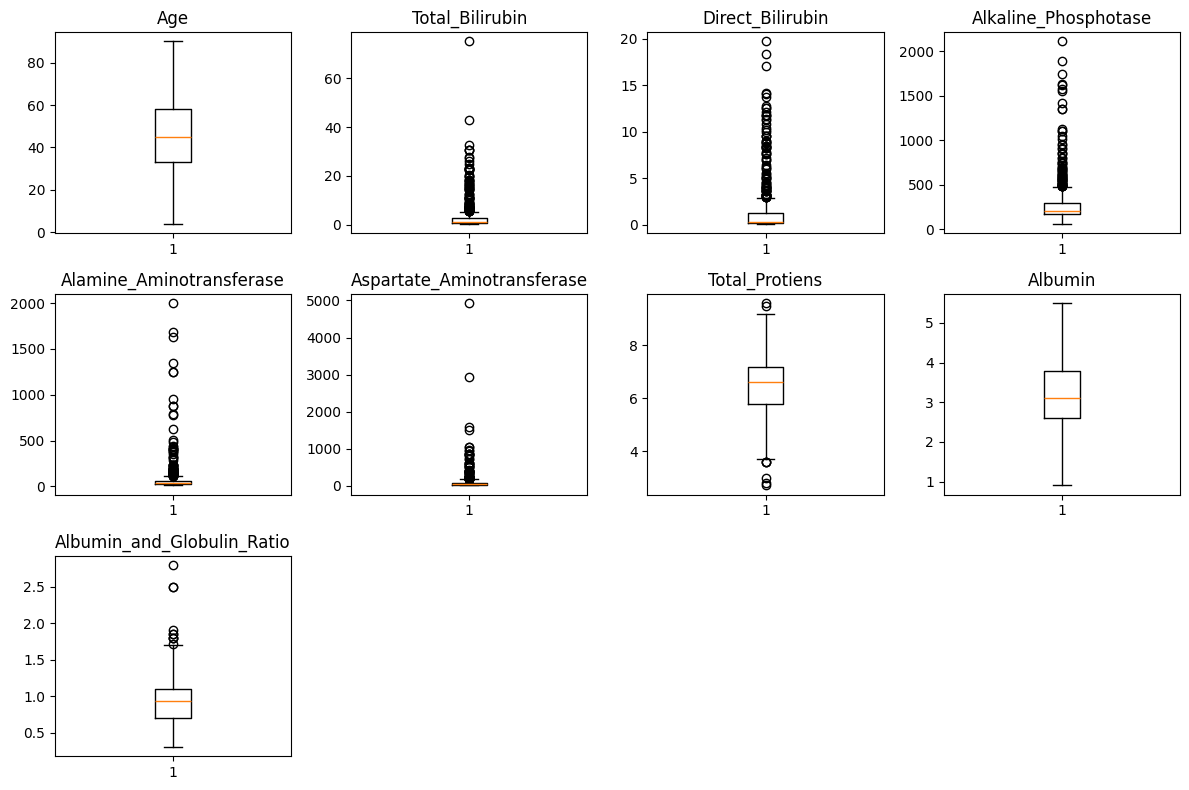

In [365]:
n = len(numerical_features)
cols = 4
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

axes= axes.flatten()

for i, col in enumerate(numerical_features):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Violin Plots by Class

C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\4277883897.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[i], x=target_col, y=col, data=df,
C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\4277883897.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[i], x=target_col, y=col, data=df,
C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\4277883897.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[i], x=target_col, y=col, data=df,
C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\4277883897.py:9

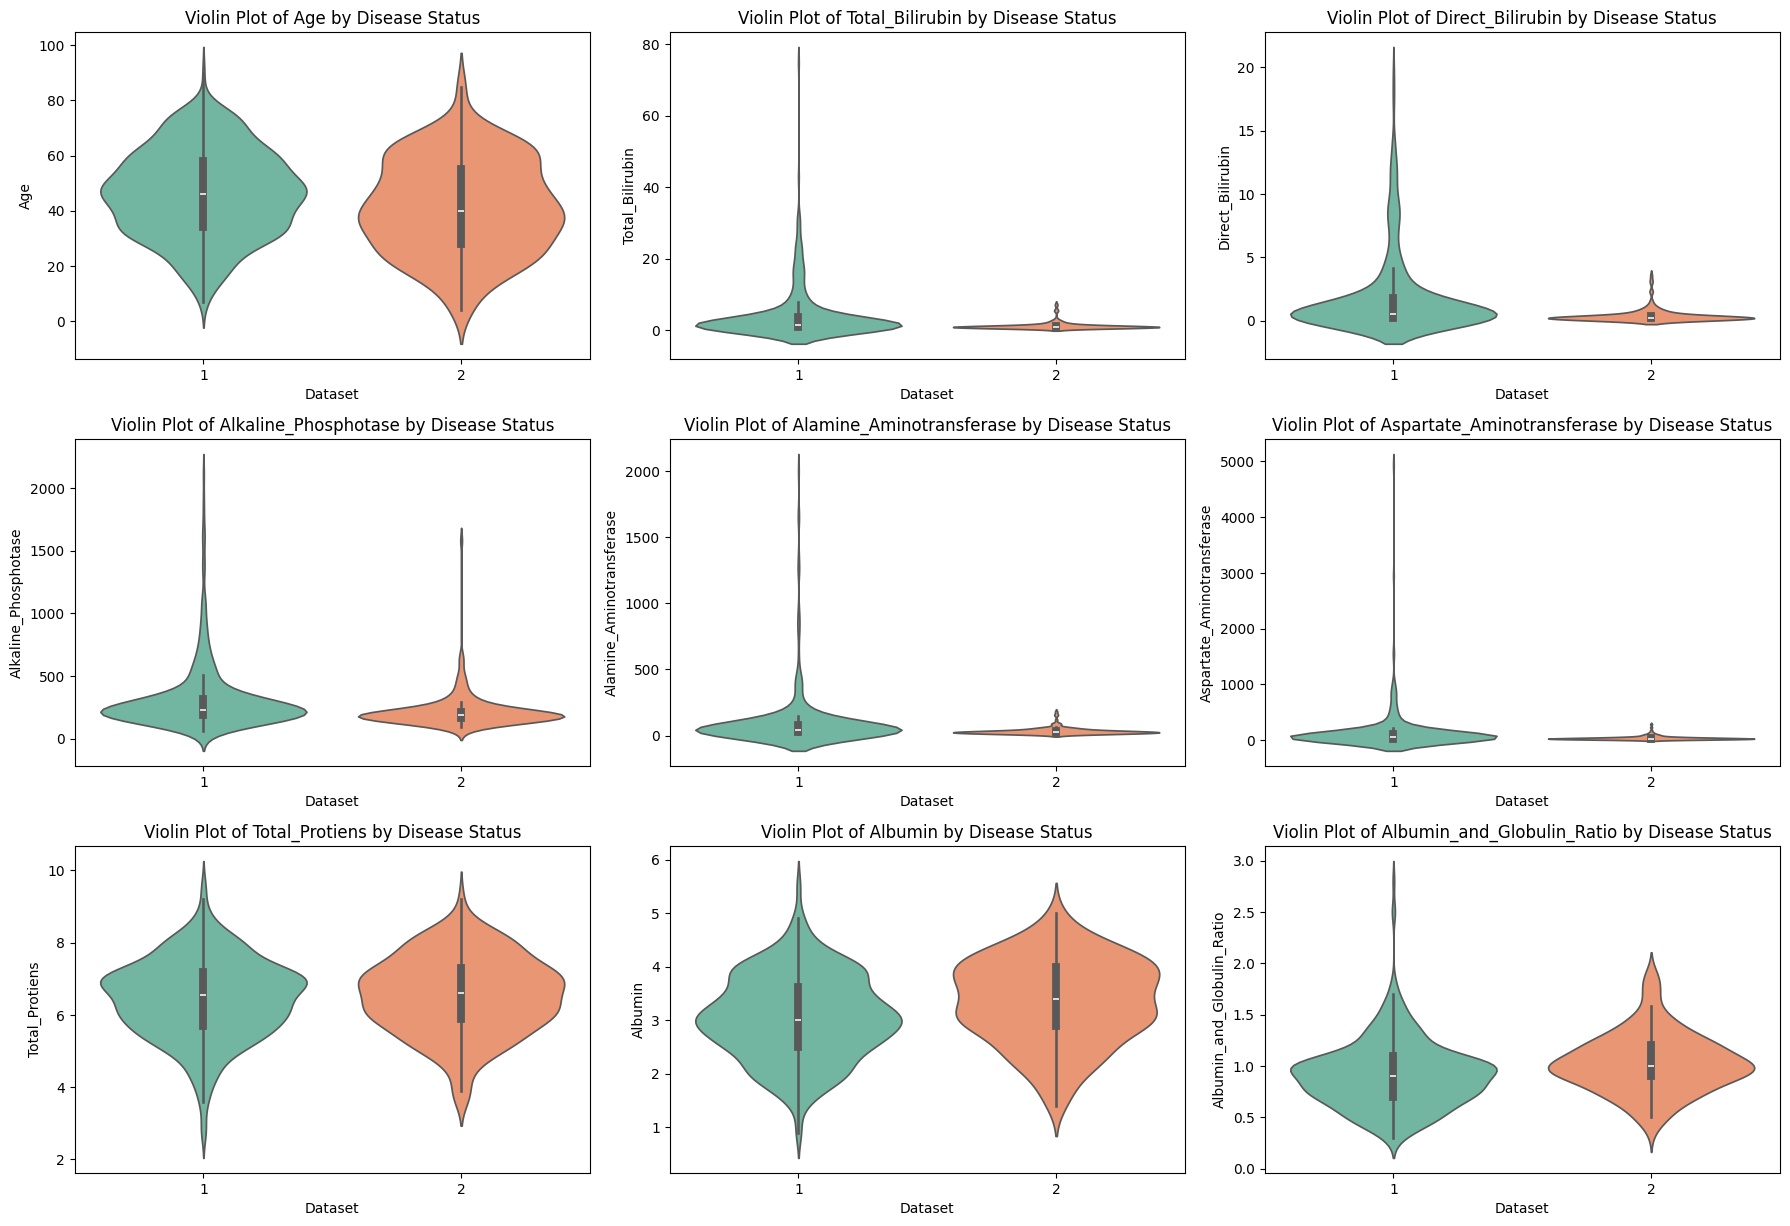

In [366]:
n = len(numerical_features)
cols = 3        
rows = 4

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.violinplot(ax=axes[i], x=target_col, y=col, data=df,
                   palette="Set2", inner="box")  
    axes[i].set_title(f"Violin Plot of {col} by Disease Status")

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Correlation Heatmap

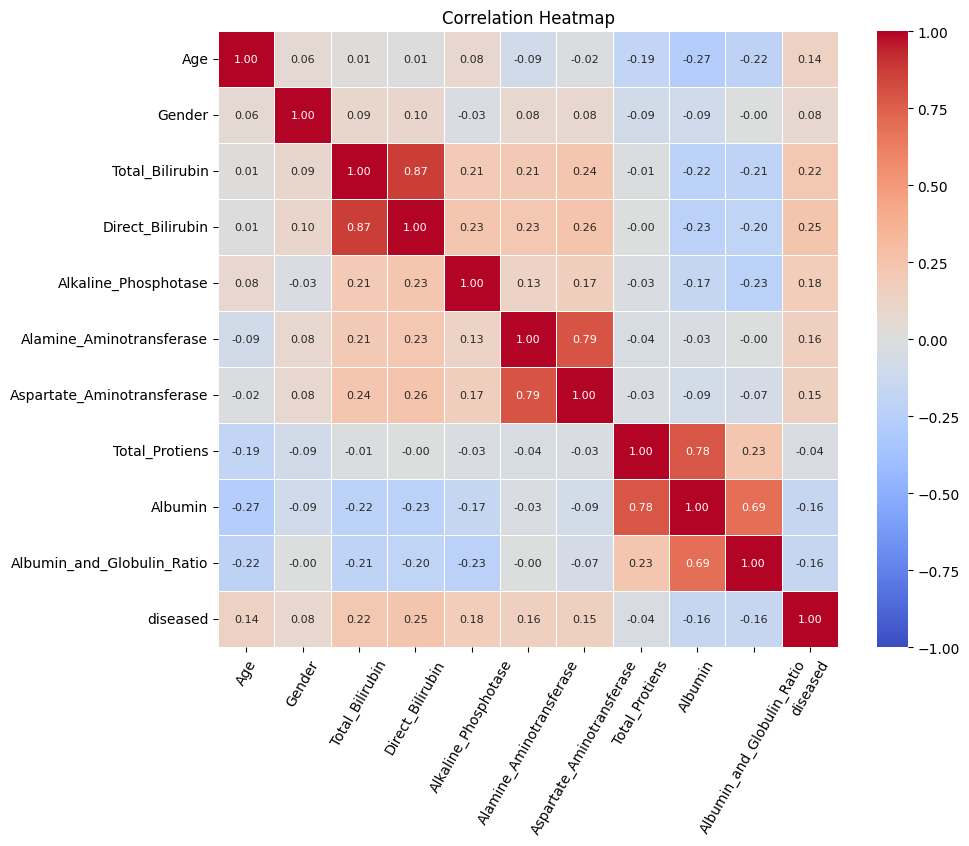

In [367]:

# Transform categorical features to numeric for correlation analysis
df_encoded = df.copy()
for c in categorical_features:
    le = LabelEncoder()
    df_encoded[c] = le.fit_transform(df_encoded[c].astype(str))

plt.figure(figsize=(10, 8))
corr = df_encoded.corr()
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,        # show correlation numbers
    fmt=".2f",         # format numbers with 2 decimals
    annot_kws={"size":8},
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

## Min and Max values for numerical atributes

In [368]:
min_max_table = pd.DataFrame({
    'Attribute': numerical_features,
    'Min': [df[col].min() for col in numerical_features],
    'Max': [df[col].max() for col in numerical_features]
})
print("\n### Min and Max Values for Numerical Attributes:\n")
print(min_max_table)


### Min and Max Values for Numerical Attributes:

                    Attribute   Min     Max
0                         Age   4.0    90.0
1             Total_Bilirubin   0.4    75.0
2            Direct_Bilirubin   0.1    19.7
3        Alkaline_Phosphotase  63.0  2110.0
4    Alamine_Aminotransferase  10.0  2000.0
5  Aspartate_Aminotransferase  10.0  4929.0
6              Total_Protiens   2.7     9.6
7                     Albumin   0.9     5.5
8  Albumin_and_Globulin_Ratio   0.3     2.8


## General observation

In [369]:
print("\n### Summary Notes:")
print(f"- Number of observations: {df.shape[0]}")
print(f"- Number of variables: {df.shape[1]}")
print(f"- Numeric variables: {len(numerical_features)} | Categorical variables: {len(categorical_features)}")
print(f"- Missing values: {df.isnull().sum().sum()} total")


### Summary Notes:
- Number of observations: 583
- Number of variables: 11
- Numeric variables: 9 | Categorical variables: 1
- Missing values: 4 total


## Distribution by class  (Boxplot)

C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\1472513961.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diseased', y=col, data=df, palette='Set2')


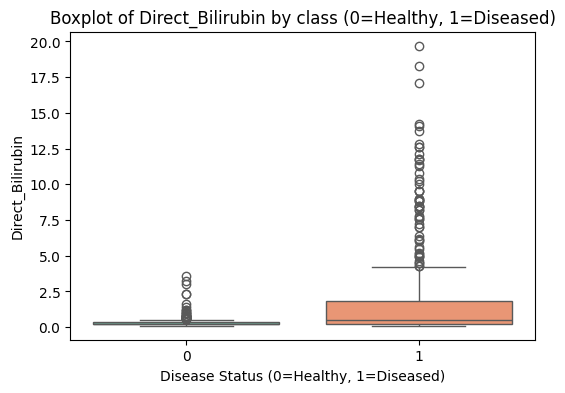

C:\Users\Wang Jin\AppData\Local\Temp\ipykernel_1672\1472513961.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diseased', y=col, data=df, palette='Set2')


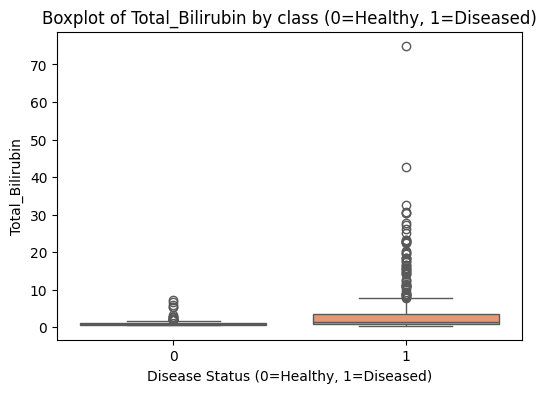

In [370]:
# Map top2 to the actual column names in df
top2_actual = ['Direct_Bilirubin', 'Total_Bilirubin']

for col in top2_actual:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='diseased', y=col, data=df, palette='Set2')
    plt.title(f"Boxplot of {col} by class (0=Healthy, 1=Diseased)")
    plt.xlabel("Disease Status (0=Healthy, 1=Diseased)")
    plt.ylabel(col)
    plt.show()

## EDA conclusions

In [371]:
print("\n### EDA Conclusions:")
print(f"- Variables most correlated with the disease: {top2[0]} ({target_corr[top2[0]]:.2f}), {top2[1]} ({target_corr[top2[1]]:.2f})")

df['diseased'].value_counts(normalize=True)


### EDA Conclusions:
- Variables most correlated with the disease: direct_bilirubin (0.25), total_bilirubin (0.22)


diseased
1    0.713551
0    0.286449
Name: proportion, dtype: float64

# Data Split

In [372]:
# Define features and target variable
X = df.drop('diseased', axis=1)
y = df['diseased']

# FIX: stratify should be the response variable 'y'
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # this is the correction
)

print("--- 1. Stratified Holdout Split ---")
print(f"Training size (for CV): {X_train.shape[0]}")
print(f"Test size (Holdout): {X_test.shape[0]}")

--- 1. Stratified Holdout Split ---
Training size (for CV): 466
Test size (Holdout): 117


# ZeroR

In [373]:
# BASELINE MODEL (ZeroR) ---
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

zeror_acc = accuracy_score(y_test, y_pred_dummy)
print(f"Accuracy del modelo base (ZeroR): {zeror_acc:.4f}")

Accuracy del modelo base (ZeroR): 0.7094


# KNN MODEL

In [374]:
# DEFINITION OF ROBUST PIPELINE (PREPROCESSING) ---

# Using pipeline + GridSearchCV ensures no data leakage between training and test sets.
# Pipeline for Numeric Data (Imputation and Standardization)
# CORRECTED CODE FOR numeric_transformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputation with mean (learns from train)
    ('scaler', StandardScaler()),                 # Standardization (learns from train)
    ('select_kbest', SelectKBest(score_func=f_classif)) # Feature selection (learns from train)
    # Only the 2 numeric variables with the highest F-value will be passed.
    # All other numeric variables are removed from the dataset.
    # A higher F-value indicates a more predictive feature.
])

# Pipeline for Categorical Data (Imputation and One-Hot Encoding) 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing values with mode
    ('onehot', OneHotEncoder())     # One-Hot Encoding
])

# Combination of Transformers (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
        ,
        ('cat', categorical_transformer, categorical_features) # <-- Using 'cat'
    ],
    remainder='passthrough'
)

# Definition of Final Pipeline (Preprocessing -> KNN)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

In [375]:
# HYPERPARAMETER TUNING (INTERNAL VALIDATION with CV=10)

# Define Hyperparameter Space
param_grid = {
    # 'knn__' prefix links to the 'knn' step in Pipeline
    'knn__n_neighbors': list(range(1, 51, 2)), # odd k values for binary classification
    'knn__metric': ['euclidean', 'manhattan'], 
    'knn__weights': ['uniform', 'distance'],
    'preprocessor__num__select_kbest__k': list(range(1, 10))
}

# Grid Search with Cross Validation (CV=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='accuracy', # Metric to select best HP combination
    cv=cv,
    verbose=0,
    n_jobs=-1
)

print("\n--- 2. Grid Search and Internal Validation (CV=10) ---")
print("Pipeline ensures: Imputation and Scaling are fitted ONLY on Training Folds.")

# Execute Grid Search (on 80% Training Set)
grid_search.fit(X_train, y_train)

# Get Best Hyperparameters
best_params = grid_search.best_params_
print("\n* Best HP combination found:", best_params)
print(f"* Best Average Accuracy (CV): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_ # This is the final model with best HP


--- 2. Grid Search and Internal Validation (CV=10) ---
Pipeline ensures: Imputation and Scaling are fitted ONLY on Training Folds.

* Best HP combination found: {'knn__metric': 'euclidean', 'knn__n_neighbors': 47, 'knn__weights': 'distance', 'preprocessor__num__select_kbest__k': 6}
* Best Average Accuracy (CV): 0.7402


In [376]:
# Extra: To find out the 6 most relevant numeric variables selected:
# 1. Access the ColumnTransformer object from the best model
column_transformer = best_model.named_steps['preprocessor']

# 2. Access the Numeric Pipeline ('num')
numeric_pipeline = column_transformer.named_transformers_['num']

# 3. Access the SelectKBest selector ('select_kbest') inside the Numeric Pipeline
kbest_selector = numeric_pipeline.named_steps['select_kbest']

# 4. Get the Boolean indices of the selected features (True if kept)
selected_mask = kbest_selector.get_support()

# 5. Use the mask to filter the original feature names
# IMPORTANT: This assumes the list 'numerical_features' is available
best_features = [
    feature for i, feature in enumerate(numerical_features) if selected_mask[i]
]

print("\n--- Selected Numeric Variables ---")
print(f"The {kbest_selector.k} most relevant numeric features are:")
print(best_features)


--- Selected Numeric Variables ---
The 6 most relevant numeric features are:
['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase']


In [377]:
# Base model without hyperparameter tuning (default HP) - for comparison

# 1. Define base pipeline (reuses the preprocessor)
# KNeighborsClassifier() is initialized with default hyperparameters (n_neighbors=5, weights='uniform', metric='minkowski')
base_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())  # default HP
])

print("\n--- Base Model (Default HP) ---")

# 2. Train the base model (only on the 80% training set)
base_model_pipeline.fit(X_train, y_train)

# 3. Predict on the test set (20% holdout)
y_pred_base = base_model_pipeline.predict(X_test)

# 4. Evaluate the base model
print("\n* Metrics on the Test Set (Holdout 20%) - Base *")

final_accuracy_base = accuracy_score(y_test, y_pred_base)
final_precision_base = precision_score(y_test, y_pred_base, average='weighted', zero_division=0)
final_f1_score_base = f1_score(y_test, y_pred_base, average='weighted', zero_division=0)

print(f"-> Base Accuracy: {final_accuracy_base:.4f}")
print(f"-> Base Precision (weighted): {final_precision_base:.4f}")
print(f"-> Base F1-Score (weighted): {final_f1_score_base:.4f}")

# --- Comparison with the optimized model ---

# Ensure that the metrics for the best GridSearch model are available
# If the GridSearch was run earlier, you can compute:
# final_accuracy_optimized = accuracy_score(y_test, best_model.predict(X_test))

print("\n--- COMPARISON SUMMARY ---")
print(f"Optimized Accuracy (GridSearch): {accuracy_score(y_test, best_model.predict(X_test)):.4f}")
print(f"Base Accuracy (Default HP): {final_accuracy_base:.4f}")



--- Base Model (Default HP) ---

* Metrics on the Test Set (Holdout 20%) - Base *
-> Base Accuracy: 0.6838
-> Base Precision (weighted): 0.6492
-> Base F1-Score (weighted): 0.6579

--- COMPARISON SUMMARY ---
Optimized Accuracy (GridSearch): 0.7265
Base Accuracy (Default HP): 0.6838


c:\Users\Wang Jin\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(



--- 3. Final Evaluation on Test Set (20% Holdout) ---
-> Accuracy (Global Precision): 0.7265
-> Precision (Weighted): 0.7023
-> F1-Score (Precision/Recall Balance): 0.6604
-> Recall (Weighted Sensitivity): 0.7265
-> Balanced Accuracy: 0.7144
-> Precision (Positive Class '1'): 0.7339
-> Recall (Positive Class '1'): 0.9639
-> F1-Score (Positive Class '1'): 0.8333


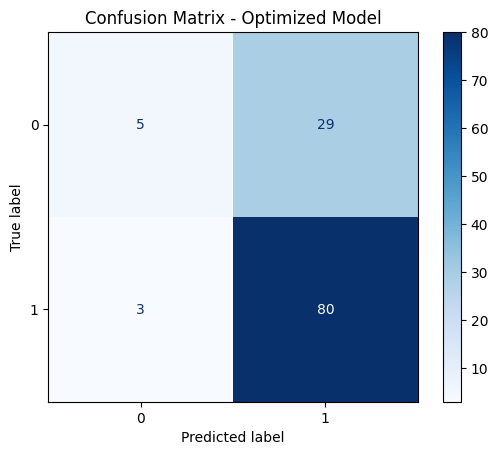

In [378]:
# FINAL EVALUATION (EXTERNAL VALIDATION with HOLD OUT) ---

# Prediction on Test Set (20% Holdout)
# The Pipeline applies the transformation (imputation/scaling) learned from X_train to X_test
y_pred = best_model.predict(X_test)

# Evaluation with Multiple Metrics
print("\n--- 3. Final Evaluation on Test Set (20% Holdout) ---")

# Calculate requested metrics
final_accuracy = accuracy_score(y_test, y_pred)

# Use 'weighted' to average classification metrics for multiple classes
final_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
final_f1_score = f1_score(y_test, y_pred, average='weighted', zero_division=0)
final_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
final_balance_accuracy = (final_precision + final_recall) / 2

# Use positive class '1' (diseased)
final_precision_pos = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
final_recall_pos = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
final_f1_score_pos = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"-> Accuracy (Global Precision): {final_accuracy:.4f}")
print(f"-> Precision (Weighted): {final_precision:.4f}")
print(f"-> F1-Score (Precision/Recall Balance): {final_f1_score:.4f}")
print(f"-> Recall (Weighted Sensitivity): {final_recall:.4f}")
print(f"-> Balanced Accuracy: {final_balance_accuracy:.4f}")
print(f"-> Precision (Positive Class '1'): {final_precision_pos:.4f}")
print(f"-> Recall (Positive Class '1'): {final_recall_pos:.4f}")
print(f"-> F1-Score (Positive Class '1'): {final_f1_score_pos:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['knn'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Optimized Model")
plt.show()

In [379]:
# --- FINAL EVALUATION CODE ---
print("\n\n--- Training and Evaluation on the FULL DATASET (X) ---")

# Clone the best Pipeline to avoid modifying the one already used for final evaluation
# It's important to refit the Pipeline on ALL data so the imputer and scaler
# learn the final statistics (mean, std, mode) from the complete X.
final_deployment_model = best_model.set_params(**best_params)
# Clone the final Pipeline and ensure we use the best hyperparameters.

# Refit the Pipeline on the FULL DATASET (X)
# The Pipeline learns the final imputation/scaling statistics from X.
final_deployment_model.fit(X, y)
print("Final pipeline retrained on 100% of the data.")



--- Training and Evaluation on the FULL DATASET (X) ---
Final pipeline retrained on 100% of the data.


## PCA

PCA creates a simpler, cleaner, and non-redundant feature space.

In [380]:
# Pipeline PCA
knn_pca_clf = Pipeline(steps=[
    ('preprocessor', preprocessor), #Imputation and Scaling
    ('pca', PCA()), # PCA
    ('knn', KNeighborsClassifier())
])

# Define hyparameters space (PCA)
param_grid_pca = {
    # reduction components
    'pca__n_components': range(1, 6), 
    'knn__n_neighbors': range(1, 51, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Configuration GridSearchCV
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search_pca = GridSearchCV(
    knn_pca_clf,
    param_grid_pca,
    cv=cv_strategy,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search with PCA optimization...")
grid_search_pca.fit(X_train, y_train) 
print(f"Best parameters with PCA: {grid_search_pca.best_params_}")
print(f"Best CV Accuracy with PCA: {grid_search_pca.best_score_:.4f}")

# Metrics on the test set with PCA
best_model_pca = grid_search_pca.best_estimator_
y_pred_pca = best_model_pca.predict(X_test)
final_accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Test Set Accuracy with PCA: {final_accuracy_pca:.4f}")
final_recall_pca = recall_score(y_test, y_pred_pca, average='weighted', zero_division=0)
print(f"Test Set Recall with PCA: {final_recall_pca:.4f}")
final_precision_pca = precision_score(y_test, y_pred_pca, average='weighted', zero_division=0)
print(f"Test Set Precision with PCA: {final_precision_pca:.4f}")
final_f1_score_pca = f1_score(y_test, y_pred_pca, average='weighted', zero_division=0)
print(f"Test Set F1-Score with PCA: {final_f1_score_pca:.4f}")

Starting Grid Search with PCA optimization...
Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best parameters with PCA: {'knn__metric': 'manhattan', 'knn__n_neighbors': 45, 'knn__weights': 'distance', 'pca__n_components': 2}
Best CV Accuracy with PCA: 0.7318
Test Set Accuracy with PCA: 0.7009
Test Set Recall with PCA: 0.7009
Test Set Precision with PCA: 0.6340
Test Set F1-Score with PCA: 0.6233


c:\Users\Wang Jin\miniconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


In [405]:
# Get the PCA components and explained variance
pca_step = best_model_pca.named_steps['pca']
n_components = pca_step.n_components_
explained_variance = pca_step.explained_variance_ratio_

print(f"Number of PCA components selected: {n_components}")
print("\nExplained variance ratio per component:")
for i, var in enumerate(explained_variance, 1):
    print(f"Component {i}: {var:.4f} ({var*100:.2f}%)")
print(f"\nTotal variance explained: {sum(explained_variance)*100:.2f}%")

# Get feature names after preprocessing
feature_names = get_feature_names_out(best_model_pca)

# Get the components (loadings)
components = pca_step.components_

# Create a DataFrame with the components
components_df = pd.DataFrame(
    components,
    columns=feature_names,
    index=[f'PC{i+1}' for i in range(n_components)]
)

print("\nPCA Components (loadings):")
print(components_df)

Number of PCA components selected: 2

Explained variance ratio per component:
Component 1: 0.3103 (31.03%)
Component 2: 0.2244 (22.44%)

Total variance explained: 53.47%

PCA Components (loadings):
          Age  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
PC1  0.110538         0.456937          0.447344              0.234856   
PC2 -0.297941         0.203245          0.204405             -0.012215   

     Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
PC1                  0.293677                    0.332338       -0.279667   
PC2                  0.413924                    0.396303        0.389545   

      Albumin  Albumin_and_Globulin_Ratio  Gender_Female  Gender_Male  
PC1 -0.397433                   -0.297982      -0.032100     0.032100  
PC2  0.455331                    0.374857       0.002587    -0.002587  


# Decision Tree Classification Model

## Preprocessing Pipeline


In [381]:
# Numerical Pipeline: Impute (Mean) -> Scale (StandardScaler)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) # Handles the 4 missing values in A_G_Ratio              
])

# Categorical Pipeline: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Converts 'Gender' to dummy variables
])

# Column Transformer: Applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Full Decision Tree Pipeline (BASE)
base_dt_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

print("Preprocessing Pipeline defined successfully.")

Preprocessing Pipeline defined successfully.


## Get Feature Names After Preprocessing

In [382]:
def get_feature_names_out(pipeline):
    """
    Correctly extracts feature names after the ColumnTransformer step.
    This works by inspecting the 'transformers_' list inside the ColumnTransformer.
    """
    preprocessor = pipeline.named_steps['preprocessor']
    output_features = []
    
    # 1. Get Numerical Feature Names (Assumes they are the first transformer: 'num')
    # Access the list of features for the 'num' transformer
    numeric_features = preprocessor.transformers_[0][2]
    output_features.extend(numeric_features)
    
    # 2. Get Categorical Feature Names (Assumes they are the second transformer: 'cat')
    # The 'cat' transformer is a Pipeline, so we access its steps
    
    # Get the actual Pipeline object for the 'cat' step
    # preprocessor.transformers_[1] returns a tuple: ('cat', Pipeline_Object, ['Gender'])
    cat_pipeline_object = preprocessor.transformers_[1][1] 
    
    # Now, the inner 'cat_pipeline_object' *is* a Pipeline, so you can use named_steps!
    ohe_encoder = cat_pipeline_object.named_steps['onehot']
    
    # Generate names for encoded categories
    encoded_feature_names = [f"Gender_{cat}" for cat in ohe_encoder.categories_[0]]
    output_features.extend(encoded_feature_names)
    
    return output_features

## Plot Tree and Print Importance

In [383]:
def analyze_decision_tree_model(model_pipeline, model_name, X_train):
    """
    Analyzes a fitted Decision Tree Pipeline: Plots the tree and prints feature importance.
    """
    print(f"\n=======================================================")
    print(f"ANALYSIS: {model_name}")
    print(f"=======================================================")

    # 1. Get the list of preprocessed feature names
    feature_names_list = get_feature_names_out(model_pipeline)

    # 2. Extract the Decision Tree Classifier object
    dt_classifier = model_pipeline.named_steps['classifier']

    # ----------------------------------------------------------------
    # A. Feature Importance
    # ----------------------------------------------------------------
    print("\n--- Feature Importance ---")
    importances = dt_classifier.feature_importances_
    
    # Create DataFrame for clean display
    importance_df = pd.DataFrame({
        'Feature': feature_names_list,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    print(importance_df.head(10).to_string(index=False)) # Show top 10 for brevity

    # ----------------------------------------------------------------
    # B. Decision Tree Plot
    # ----------------------------------------------------------------
    plt.figure(figsize=(25, 12))
    plt.title(f"Decision Tree Structure: {model_name} (Max Depth 3 for Clarity)")
    
    # Plotting the tree
    plot_tree(
        dt_classifier,
        feature_names=feature_names_list,
        class_names=['Healthy (0)', 'Sick (1)'],
        filled=True,
        rounded=True,
        max_depth=5 # Restrict depth for better visualization (full tree is too large)
    )
    plt.show()

## Hyperparameter Tuning for Decision Tree Classifier (accuracy)

In [384]:
# Define the hyperparameter search space
param_grid = {
    'classifier__max_depth': range(3, 20),
    'classifier__min_samples_leaf': range(10, 45),
    'classifier__criterion': ['gini', 'entropy']
}

# Use StratifiedKFold for cross-validation due to class imbalance
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Configure GridSearchCV
grid_search = GridSearchCV(
    base_dt_clf,
    param_grid,
    cv=cv_strategy,
    scoring='accuracy', # Required metric for the search
    n_jobs=-1,
    verbose=1
)

# Perform the Grid Search on the training data
print("\nStarting 10-Fold Grid Search for Decision Tree...")
grid_search.fit(X_train, y_train)

# Store the best model and parameters
best_dt_model = grid_search.best_estimator_
best_score = grid_search.best_score_

print(f"\n--- Grid Search Results ---")
print(f"Best parameters found (Tuned for Accuracy): {grid_search.best_params_}")
print(f"Best cross-validation Accuracy (k=10): {best_score:.4f}")


Starting 10-Fold Grid Search for Decision Tree...
Fitting 10 folds for each of 1190 candidates, totalling 11900 fits

--- Grid Search Results ---
Best parameters found (Tuned for Accuracy): {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 16}
Best cross-validation Accuracy (k=10): 0.7083


In [385]:
def evaluate_model(model, X_test, y_test, model_name, zeroR_baseline=0.7094):
    """Evaluates the model and prints the required metrics."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Required Metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1) # Priority: Recall of the positive class (1/Sick)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- Evaluation Report: {model_name} ---")
    print(f"Accuracy: {accuracy:.4f} ({'SUPERIOR' if accuracy > zeroR_baseline else 'INFERIOR'} to ZeroR Baseline: {zeroR_baseline})")
    print(f"**Recall (Positive Class 1/Sick): {recall:.4f}**")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"FPs (Healthy misdiagnosed): {cm[0, 1]}, FNs (Sick missed): {cm[1, 0]}")
    
    # Detailed Report (for Precision, F1-Score, Weighted Metrics)
    print("\nClassification Report (Detailed):")
    report = classification_report(y_test, y_pred, target_names=['Healty (0)', 'Sick (1)'], output_dict=True)
    
    print(classification_report(y_test, y_pred, target_names=['Healty (0)', 'Sick (1)']))
    print(f"F1 Score (Weighted Avg): {report['weighted avg']['f1-score']:.4f}")
    
# Evaluate BASE Model
base_dt_clf.fit(X_train, y_train)
evaluate_model(base_dt_clf, X_test, y_test, "BASE Decision Tree (Default Params)")

# Evaluate TUNED Model
evaluate_model(best_dt_model, X_test, y_test, "TUNED Decision Tree (Best Params from Grid)")


--- Evaluation Report: BASE Decision Tree (Default Params) ---
Accuracy: 0.6068 (INFERIOR to ZeroR Baseline: 0.7094)
**Recall (Positive Class 1/Sick): 0.7229**
ROC AUC Score: 0.5232

Confusion Matrix:
[[11 23]
 [23 60]]
FPs (Healthy misdiagnosed): 23, FNs (Sick missed): 23

Classification Report (Detailed):
              precision    recall  f1-score   support

  Healty (0)       0.32      0.32      0.32        34
    Sick (1)       0.72      0.72      0.72        83

    accuracy                           0.61       117
   macro avg       0.52      0.52      0.52       117
weighted avg       0.61      0.61      0.61       117

F1 Score (Weighted Avg): 0.6068

--- Evaluation Report: TUNED Decision Tree (Best Params from Grid) ---
Accuracy: 0.7179 (SUPERIOR to ZeroR Baseline: 0.7094)
**Recall (Positive Class 1/Sick): 0.9759**
ROC AUC Score: 0.7725

Confusion Matrix:
[[ 3 31]
 [ 2 81]]
FPs (Healthy misdiagnosed): 31, FNs (Sick missed): 2

Classification Report (Detailed):
              

## Plots and feature importance


ANALYSIS: BASE Decision Tree (Default Params)

--- Feature Importance ---
                   Feature  Importance
      Alkaline_Phosphotase    0.203886
Aspartate_Aminotransferase    0.141142
           Total_Bilirubin    0.124807
            Total_Protiens    0.114787
                       Age    0.104929
                   Albumin    0.099742
  Alamine_Aminotransferase    0.098989
Albumin_and_Globulin_Ratio    0.055767
          Direct_Bilirubin    0.031050
               Gender_Male    0.012626


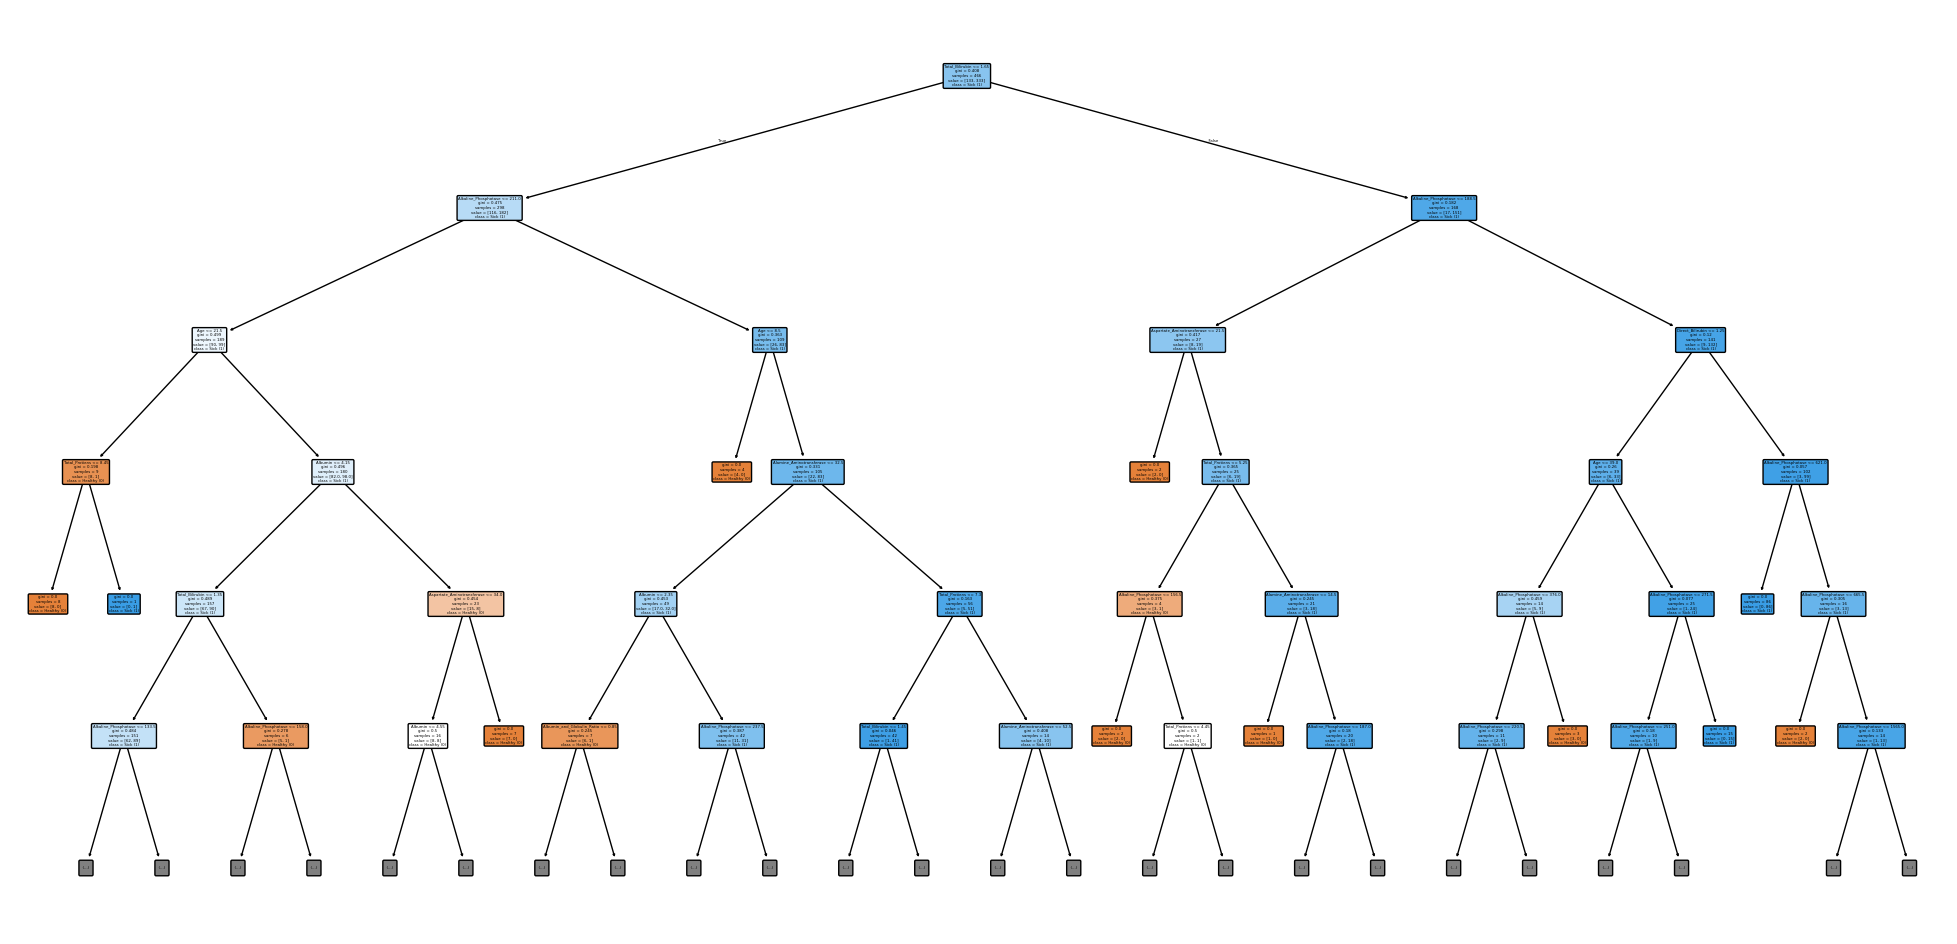


ANALYSIS: TUNED Decision Tree (Best Params)

--- Feature Importance ---
                   Feature  Importance
           Total_Bilirubin    0.470853
      Alkaline_Phosphotase    0.164167
                       Age    0.159880
          Direct_Bilirubin    0.111667
  Alamine_Aminotransferase    0.093433
Aspartate_Aminotransferase    0.000000
            Total_Protiens    0.000000
                   Albumin    0.000000
Albumin_and_Globulin_Ratio    0.000000
             Gender_Female    0.000000


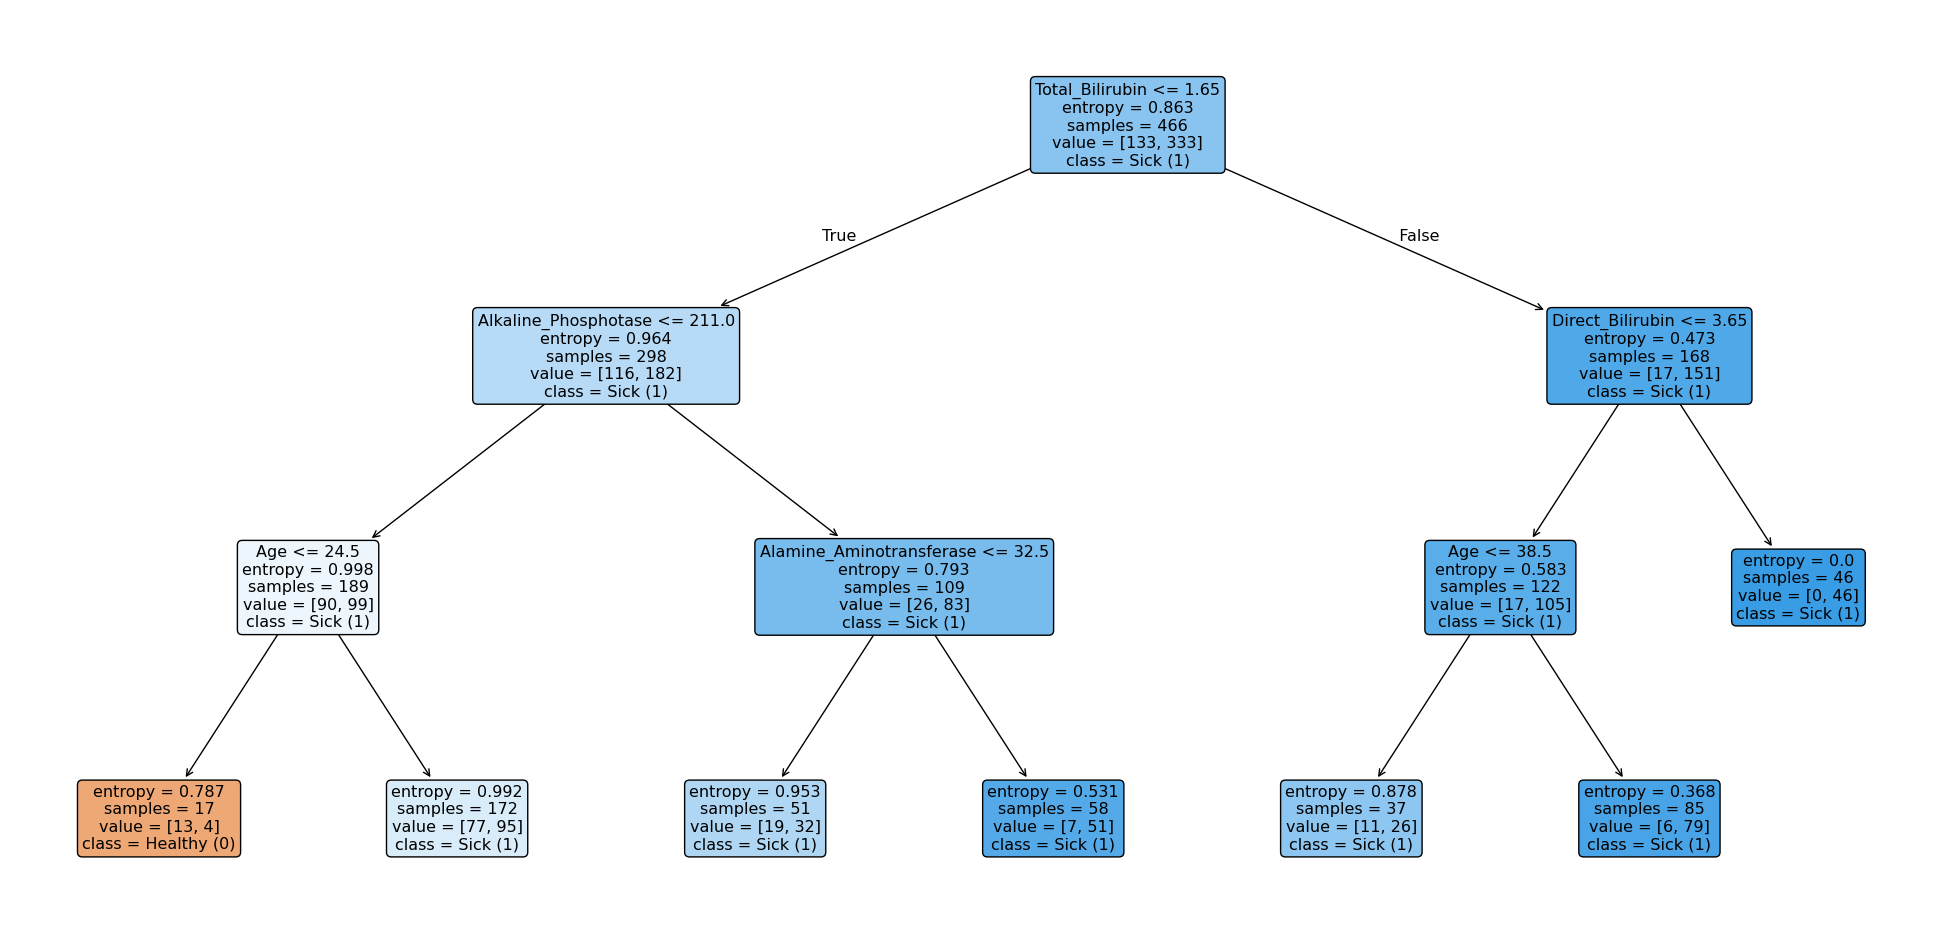

In [386]:
# --- Analysis of the BASE MODEL ---
# The Base Model shows you what the default parameters do 
analyze_decision_tree_model(base_dt_clf, "BASE Decision Tree (Default Params)", X_train)

# --- Analysis of the TUNED MODEL ---
# The Tuned Model shows you the complexity optimized for accuracy
analyze_decision_tree_model(best_dt_model, "TUNED Decision Tree (Best Params)", X_train)

## Modifying Hyperparameter Tuning to Optimize Recall (Extra)

In [387]:
# 1. Define the hyperparameter search space (same as before)
param_grid = {
    'classifier__max_depth': range(3, 20),
    'classifier__min_samples_leaf': range(10, 45),
    'classifier__criterion': ['gini', 'entropy']
}

# 3. Configure GridSearchCV, **NOW SCORING BY RECALL**
grid_search_recall = GridSearchCV(
    base_dt_clf,
    param_grid,
    cv=cv_strategy,
    scoring='recall', # <<< CRITICAL CHANGE: Optimize for Recall of the positive class (Sick)
    n_jobs=-1,
    verbose=1
)

print("\nStarting 10-Fold Grid Search, OPTIMIZING FOR RECALL...")
grid_search_recall.fit(X_train, y_train) # Execute with your actual data

# Store the best model and parameters
best_dt_model_recall = grid_search_recall.best_estimator_
best_recall_score = grid_search_recall.best_score_

print(f"\n--- Grid Search Results (Optimized for RECALL) ---")
print(f"Best parameters found: {grid_search_recall.best_params_}")
print(f"Best cross-validation RECALL (k=10): {best_recall_score:.4f}")

# Evaluate RECALL-OPTIMIZED Model
evaluate_model(best_dt_model_recall, X_test, y_test, "RECALL-OPTIMIZED Decision Tree (Best Params from Grid)")  


Starting 10-Fold Grid Search, OPTIMIZING FOR RECALL...
Fitting 10 folds for each of 1190 candidates, totalling 11900 fits

--- Grid Search Results (Optimized for RECALL) ---
Best parameters found: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 15}
Best cross-validation RECALL (k=10): 0.9553

--- Evaluation Report: RECALL-OPTIMIZED Decision Tree (Best Params from Grid) ---
Accuracy: 0.7179 (SUPERIOR to ZeroR Baseline: 0.7094)
**Recall (Positive Class 1/Sick): 0.9759**
ROC AUC Score: 0.7725

Confusion Matrix:
[[ 3 31]
 [ 2 81]]
FPs (Healthy misdiagnosed): 31, FNs (Sick missed): 2

Classification Report (Detailed):
              precision    recall  f1-score   support

  Healty (0)       0.60      0.09      0.15        34
    Sick (1)       0.72      0.98      0.83        83

    accuracy                           0.72       117
   macro avg       0.66      0.53      0.49       117
weighted avg       0.69      0.72      0.63       117

F1


ANALYSIS: RECALL-OPTIMIZED Decision Tree (Best Params)

--- Feature Importance ---
                   Feature  Importance
           Total_Bilirubin    0.470853
      Alkaline_Phosphotase    0.164167
                       Age    0.159880
          Direct_Bilirubin    0.111667
  Alamine_Aminotransferase    0.093433
Aspartate_Aminotransferase    0.000000
            Total_Protiens    0.000000
                   Albumin    0.000000
Albumin_and_Globulin_Ratio    0.000000
             Gender_Female    0.000000


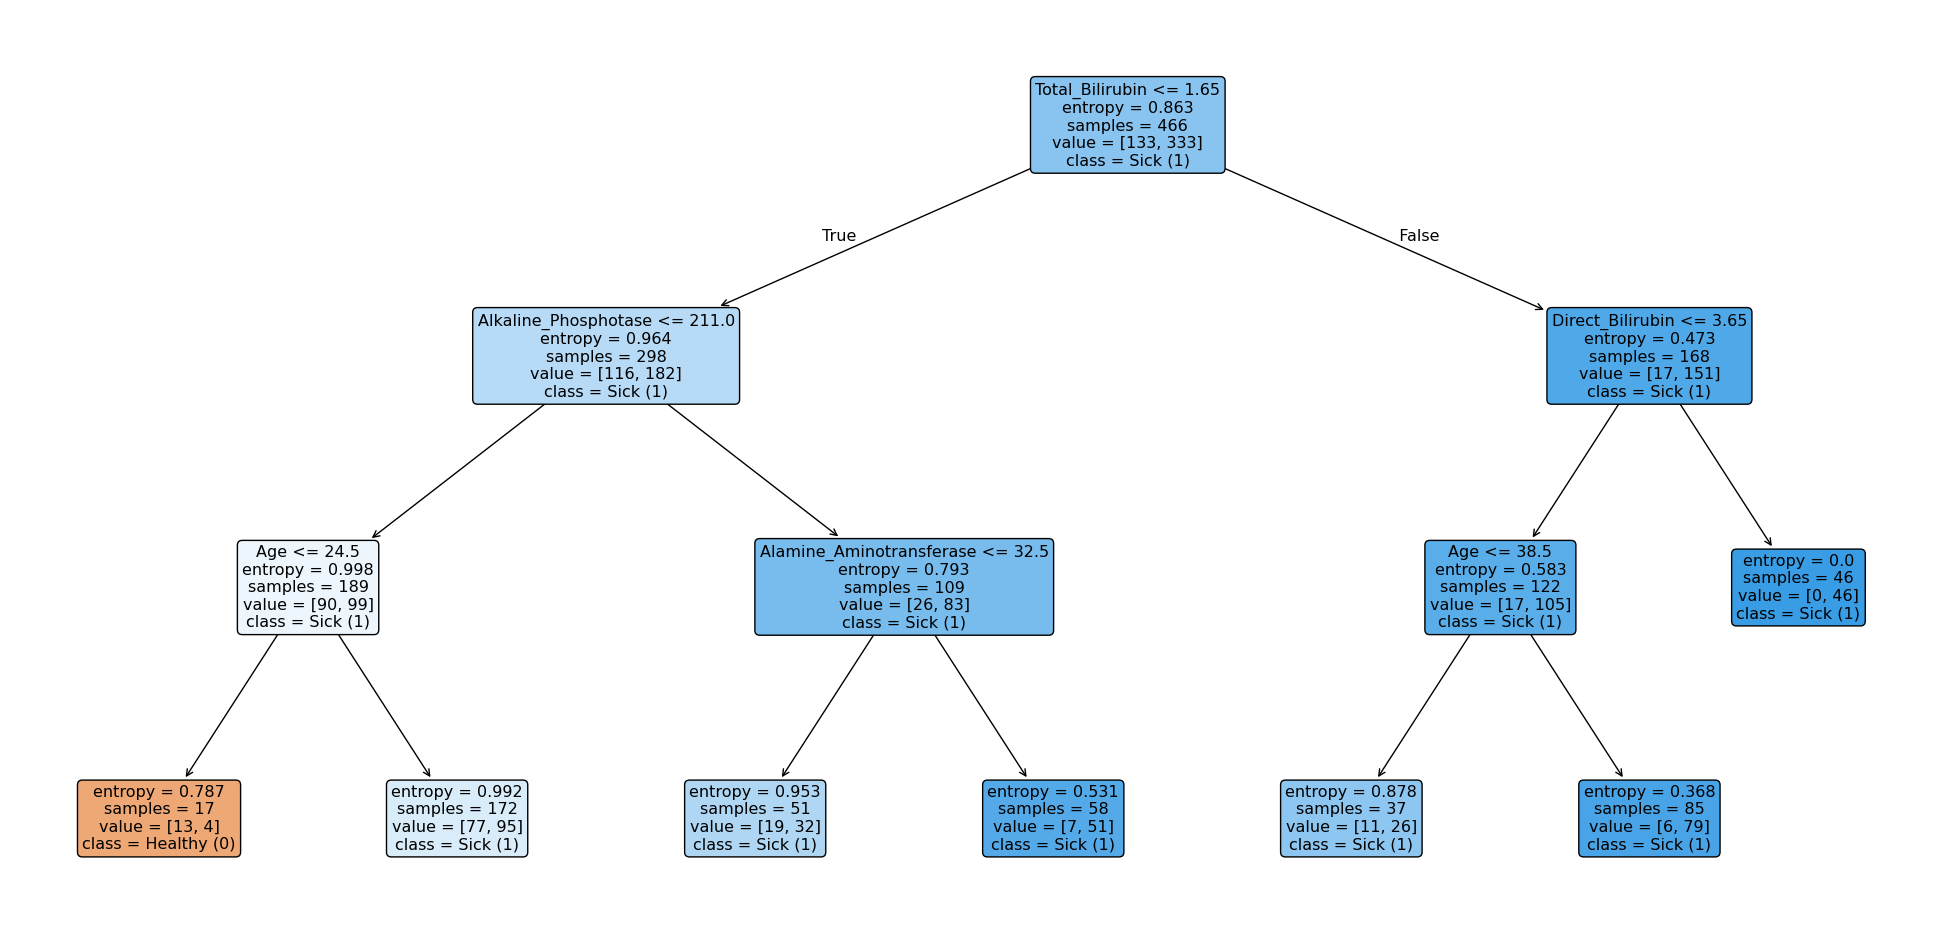

In [388]:
# --- Analysis of the RECALL-OPTIMIZED MODEL ---
analyze_decision_tree_model(best_dt_model_recall, "RECALL-OPTIMIZED Decision Tree (Best Params)", X_train)

## Over-Sampling with SMOTE

In [389]:
# Re-extract the best classifier parameters from the Grid Search
best_params_clf = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

# Build a new Pipeline using ImbPipeline to incorporate SMOTE
smote_dt_clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Over-sampling the minority class (0/Healthy)
    ('classifier', DecisionTreeClassifier(random_state=42, **best_params_clf))
])

print("\n\n--- Starting SMOTE Evaluation (Extra) ---")
smote_dt_clf.fit(X_train, y_train)
evaluate_model(smote_dt_clf, X_test, y_test, "TUNED Decision Tree with SMOTE")



--- Starting SMOTE Evaluation (Extra) ---

--- Evaluation Report: TUNED Decision Tree with SMOTE ---
Accuracy: 0.7350 (SUPERIOR to ZeroR Baseline: 0.7094)
**Recall (Positive Class 1/Sick): 0.7470**
ROC AUC Score: 0.7782

Confusion Matrix:
[[24 10]
 [21 62]]
FPs (Healthy misdiagnosed): 10, FNs (Sick missed): 21

Classification Report (Detailed):
              precision    recall  f1-score   support

  Healty (0)       0.53      0.71      0.61        34
    Sick (1)       0.86      0.75      0.80        83

    accuracy                           0.74       117
   macro avg       0.70      0.73      0.70       117
weighted avg       0.77      0.74      0.74       117

F1 Score (Weighted Avg): 0.7441



ANALYSIS: TUNED Decision Tree with SMOTE

--- Feature Importance ---
                   Feature  Importance
           Total_Bilirubin    0.476448
Aspartate_Aminotransferase    0.187436
          Direct_Bilirubin    0.132373
      Alkaline_Phosphotase    0.109486
                       Age    0.094256
  Alamine_Aminotransferase    0.000000
            Total_Protiens    0.000000
                   Albumin    0.000000
Albumin_and_Globulin_Ratio    0.000000
             Gender_Female    0.000000


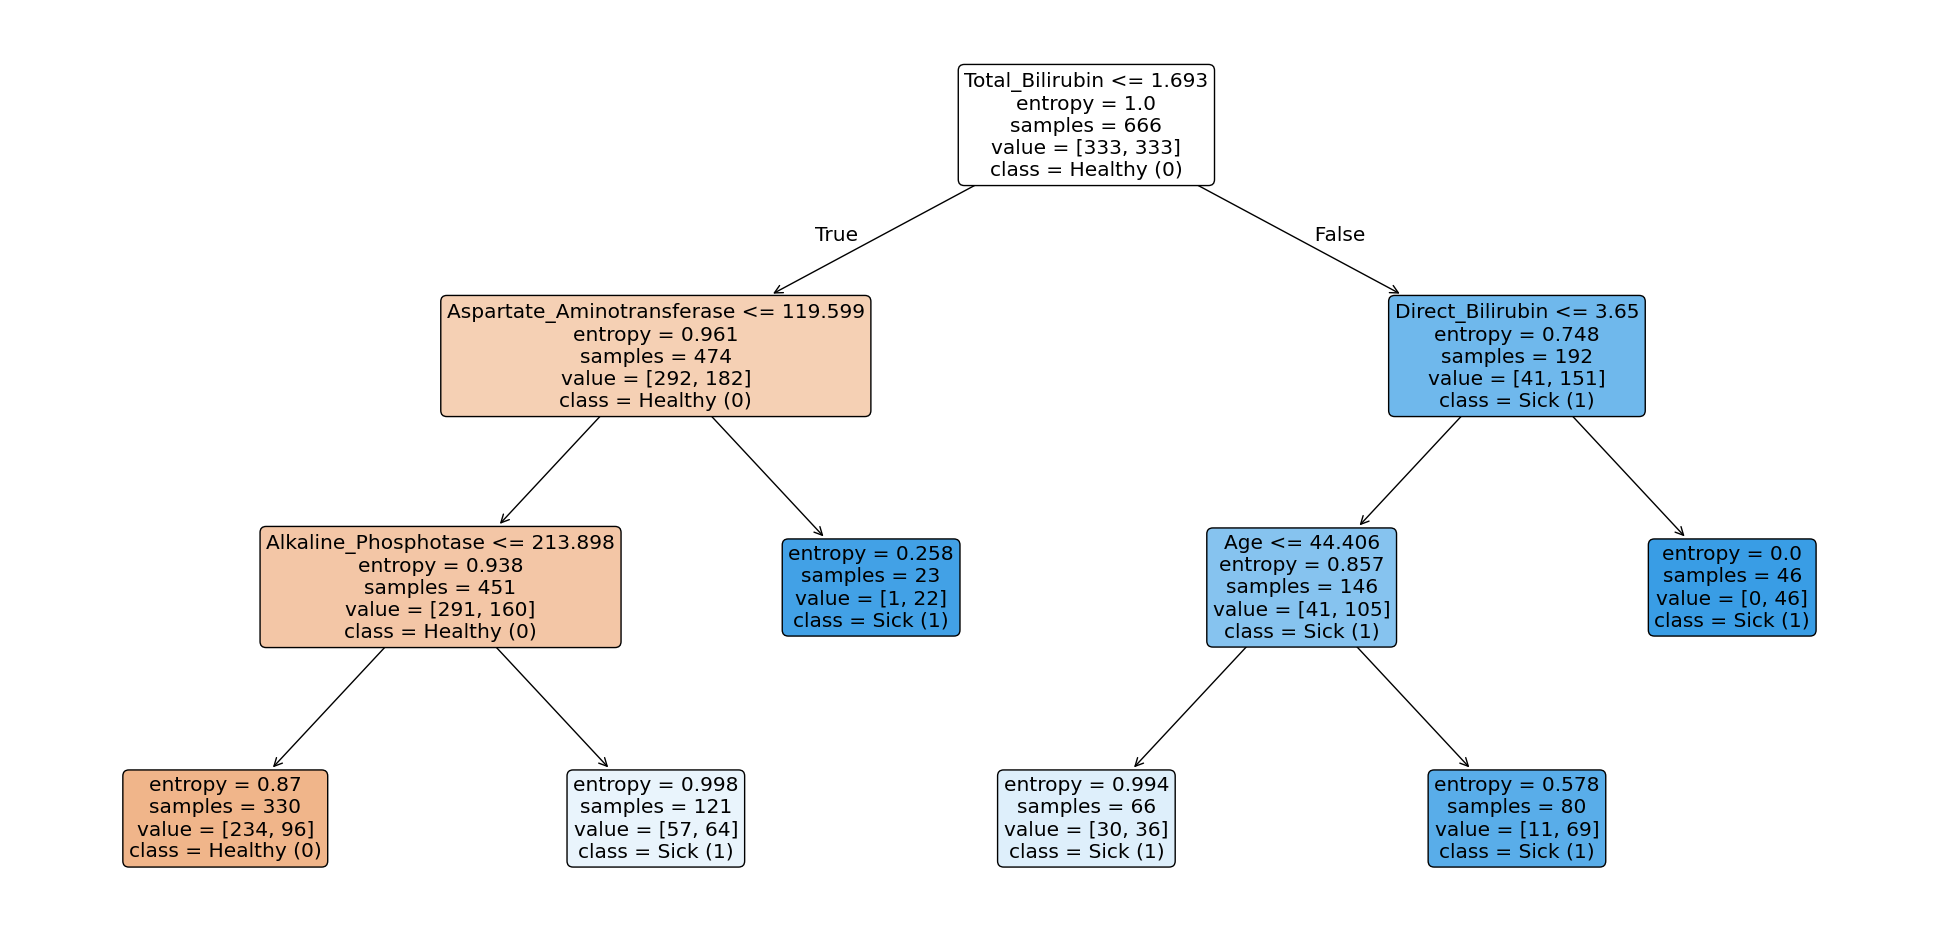

In [390]:
# --- Analysis of the SMOTE MODEL ---
analyze_decision_tree_model(smote_dt_clf, "TUNED Decision Tree with SMOTE", X_train)    

## Undersampling

Under-sampling removes instances from the majority class (Sick/1). This can reduce training time and help with precision, but often sacrifices overall accuracy and risks losing valuable data.

In [391]:
# Build a new Pipeline using ImbPipeline to incorporate RandomUnderSampler
undersample_dt_clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampler', RandomUnderSampler(random_state=42)), # Under-sampling the majority class (1/Sick)
    ('classifier', DecisionTreeClassifier(random_state=42, **best_params_clf))
])

print("\n\n--- Starting Undersampling Evaluation (Extra Credit) ---")
undersample_dt_clf.fit(X_train, y_train)
evaluate_model(undersample_dt_clf, X_test, y_test, "TUNED Decision Tree with Undersampling")



--- Starting Undersampling Evaluation (Extra Credit) ---

--- Evaluation Report: TUNED Decision Tree with Undersampling ---
Accuracy: 0.5556 (INFERIOR to ZeroR Baseline: 0.7094)
**Recall (Positive Class 1/Sick): 0.4578**
ROC AUC Score: 0.6813

Confusion Matrix:
[[27  7]
 [45 38]]
FPs (Healthy misdiagnosed): 7, FNs (Sick missed): 45

Classification Report (Detailed):
              precision    recall  f1-score   support

  Healty (0)       0.38      0.79      0.51        34
    Sick (1)       0.84      0.46      0.59        83

    accuracy                           0.56       117
   macro avg       0.61      0.63      0.55       117
weighted avg       0.71      0.56      0.57       117

F1 Score (Weighted Avg): 0.5692


## Two candidates for the "best model"

- best_dt_model_recall: The best Decision Tree configuration found by GridSearchCV when optimizing the hyperparameters for Recall on the validation folds ($\mathbf{X}_{\text{train}}$).

- smote_dt_clf: A model incorporating SMOTE (for rebalancing) and the best hyperparameters, fitted on $\mathbf{X}_{\text{train}}$.

### Train the models using the entire dataset ($\mathbf{X}$ and $\mathbf{y}$).

In [392]:
# 1. Access the best parameters found during tuning for the classifier part
# We will assume you chose the parameters optimized for RECALL.
best_params_clf = best_dt_model_recall.named_steps['classifier'].get_params()

# 2. Recreate the final pipeline structure
# Assuming 'preprocessor' is defined as before (ColumnTransformer)

final_production_model = ImbPipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', DecisionTreeClassifier(**best_params_clf))
])

print("Starting final training of the Decision Tree on ALL data (X and y)...")

# 3. Train the final model on ALL data (X and y)
final_production_model.fit(X, y)

print("Final production model training complete.")
print("This model is now ready for deployment or final submission.")

Starting final training of the Decision Tree on ALL data (X and y)...
Final production model training complete.
This model is now ready for deployment or final submission.


## Simulating Live Prediction

In [393]:
### Create Hypothetical Patient Data
data_hypothetical = {
    'Age': [55, 30, 65, 45, 70],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
    
    # High/low Bilirubin values (key for liver disease)
    'Total_Bilirubin': [15.0, 0.8, 1.5, 2.5, 4.0],  
    'Direct_Bilirubin': [8.0, 0.2, 0.7, 1.1, 2.5],   
    
    # Enzyme values (indicator of liver inflammation)
    'Alkaline_Phosphotase': [450, 80, 150, 350, 200], 
    'Alamine_Aminotransferase': [150, 20, 60, 40, 80],    
    'Aspartate_Aminotransferase': [180, 25, 65, 35, 90],    
    
    # Protein / Albumin / Ratio values (indicator of liver function)
    'Total_Protiens': [5.5, 7.5, 7.0, 6.0, 6.2],   
    'Albumin': [2.5, 4.5, 4.0, 3.5, 3.0],  
    'Albumin_and_Globulin_Ratio': [0.45, 1.50, np.nan, 0.90, 0.80]  # simulate a missing value
}

# Create the input DataFrame (X_new_patients)
X_new_patients = pd.DataFrame(data_hypothetical)

# Expected outcomes (for comparison)
expected_outcomes = [1, 0, 0, 1, 1]  # 1=Sick, 0=Healthy (P3 is a borderline healthy case, P4 is a sick case that may be missed)

print("DataFrame of 5 new patients created successfully. Ready for prediction.")
print("\nFirst rows of the input DataFrame:")
print(X_new_patients.head())


DataFrame of 5 new patients created successfully. Ready for prediction.

First rows of the input DataFrame:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   55    Male             15.0               8.0                   450   
1   30  Female              0.8               0.2                    80   
2   65    Male              1.5               0.7                   150   
3   45  Female              2.5               1.1                   350   
4   70    Male              4.0               2.5                   200   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                       150                         180             5.5   
1                        20                          25             7.5   
2                        60                          65             7.0   
3                        40                          35             6.0   
4                        80                          90           

In [394]:
# PREDICTION EXECUTION
y_pred_new = final_production_model.predict(X_new_patients)
y_proba_new = final_production_model.predict_proba(X_new_patients)[:, 1]

X_new_patients['Predicted_Outcome'] = y_pred_new
X_new_patients['Probability_Sick'] = y_proba_new.round(4)
X_new_patients['Expected_Outcome'] = expected_outcomes

print("\n--- Predictions for New Patients ---")
print(X_new_patients[['Predicted_Outcome', 'Probability_Sick', 'Expected_Outcome']])


--- Predictions for New Patients ---
   Predicted_Outcome  Probability_Sick  Expected_Outcome
0                  1            1.0000                 1
1                  1            0.5280                 0
2                  1            0.5280                 0
3                  1            0.7059                 1
4                  1            1.0000                 1
